## (a) Importing libraries

In [291]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import randint
import visualkeras
from keras.utils import plot_model
import pydotplus
import numpy as np
from scipy import stats

## (b) Data loading and preparation

In [292]:
# load datasets
white_wine = pd.read_csv('winequality-white.csv', delimiter=';')
red_wine = pd.read_csv('winequality-red.csv', delimiter=';')

In [293]:
# assign labels
white_wine['type'] = 'white'
red_wine['type'] = 'red'

In [294]:
# merge datasets
wine = pd.concat([red_wine, white_wine], axis=0)

In [295]:
num_na_rows = wine.isnull().sum(axis=1).astype(bool).sum()
total_rows = wine.shape[0]

print('Number of N/A rows: {}'.format(num_na_rows))
print('Number of total rows: {}'.format(total_rows))

#remove N/A values
wine.dropna() 
print('Number of records after removing N/A values: {}'.format(wine.shape[0]))

Number of N/A rows: 0
Number of total rows: 6497
Number of records after removing N/A values: 6497


In [296]:
# encode labels
wine['type'] = wine['type'].map({'red': 0, 'white': 1})
print(wine.head())
print(wine.columns)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0            7.4              0.70         0.00             1.9      0.076  \
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates   
0                 11.0                  34.0   0.9978  3.51       0.56  \
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  type  
0      9.4        5     0  
1      9.8        5     0  
2 

In [297]:
#remove duplicate values
wine.drop_duplicates(inplace=True)

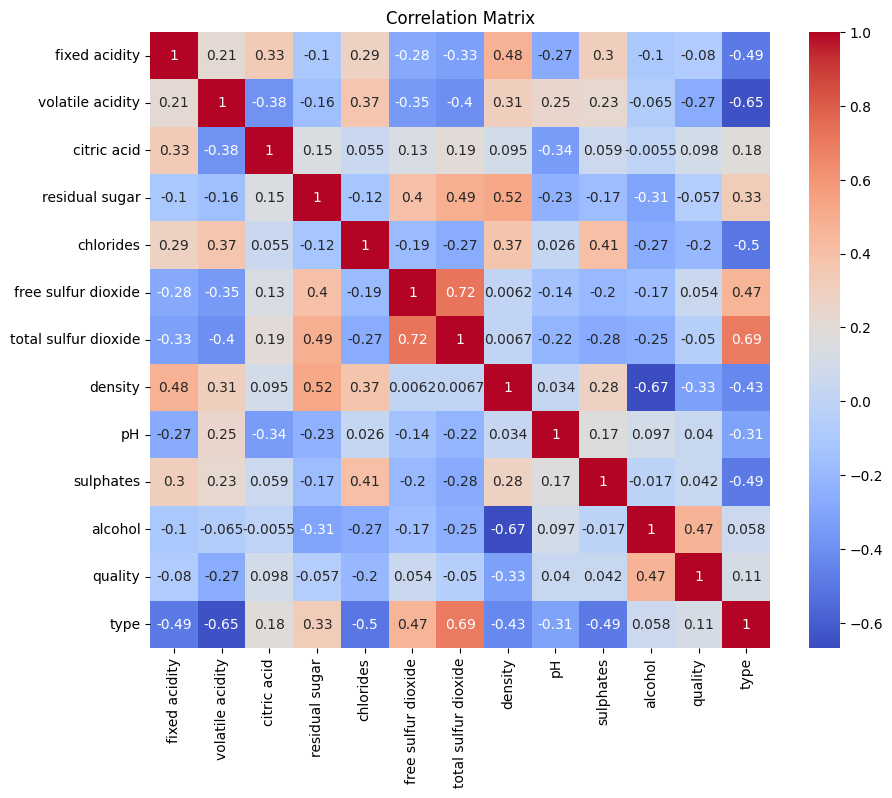

fixed acidity          -0.486253
volatile acidity       -0.645335
citric acid             0.183759
residual sugar          0.328695
chlorides              -0.499517
free sulfur dioxide     0.465326
total sulfur dioxide    0.694229
density                -0.429377
pH                     -0.310919
sulphates              -0.490364
alcohol                 0.057756
quality                 0.114809
type                    1.000000
Name: type, dtype: float64


In [298]:
# Compute the correlation matrix
corr_matrix = wine.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Extract the correlation coefficients for a specific variable
correlation_with_target = corr_matrix['type']

# Print the correlation coefficients with the target variable
print(correlation_with_target)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0          0.140064          2.115349     2.164515        0.699699   0.523880  \
1          0.443199          3.185297     2.164515        0.544135   1.120736   
2          0.443199          2.471998     1.892672        0.610806   0.957957   
3          3.019841          0.381197     1.641293        0.699699   0.496751   
5          0.140064          1.877583     2.164515        0.721923   0.496751   
...             ...               ...          ...             ...        ...   
4893       0.769339          0.797288     0.193650        0.766370   0.479922   
4894       0.466204          0.143431     0.282076        0.655929   0.262884   
4895       0.541988          0.618963     0.873259        0.855263   0.425662   
4896       1.299824          0.321755     0.125689        0.877487   0.941128   
4897       0.920906          0.797288     0.417998        0.944157   0.995388   

      free sulfur dioxide  

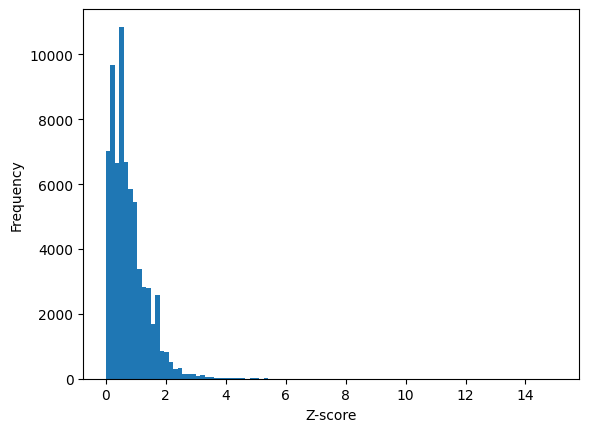

Number of rows after removing outliers using 2.5 std dev: 4356
Number of rows after removing outliers using 3 std dev: 0
Number of rows that are within std dev 2.5 to 3: 513
4356


In [299]:
# Calculate the z-scores for each data point
# z_scores = np.abs((df - df.mean()) / df.std())
z_scores = np.abs(stats.zscore(wine))
print(z_scores)

# Plot the distribution of the z-scores to understand the outliers lied at in the distribution
plt.hist(z_scores.values.flatten(), bins=100)
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.show()

# Choose a threshold based on the distribution of the z-scores
min_threshold = 2.5
max_threshold = 3.0
print('Number of rows after removing outliers using 2.5 std dev: {}'.format(wine[(z_scores < min_threshold).all(axis=1)].shape[0]))
print('Number of rows after removing outliers using 3 std dev: {}'.format(wine[(z_scores > max_threshold).all(axis=1)].shape[0]))
print('Number of rows that are within std dev 2.5 to 3: {}'.format(abs(wine[(z_scores < min_threshold).all(axis=1)].shape[0]- wine[(z_scores < max_threshold).all(axis=1)].shape[0])))

merged_df = wine[(z_scores < min_threshold).all(axis=1)]
print(merged_df.shape[0])

In [300]:
# create a MinMaxScaler object
scaler = MinMaxScaler()

wine_normalized = pd.DataFrame(scaler.fit_transform(merged_df), columns= merged_df.columns)
wine_normalized.head(20)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,0.491803,0.911765,0.000000,0.083333,0.482014,0.136986,0.112,0.737589,0.860759,0.500000,0.196078,0.333333,0.0
1,0.557377,1.000000,0.058824,0.108974,0.597122,0.191781,0.192,0.680851,0.544304,0.632353,0.274510,0.333333,0.0
2,0.491803,0.852941,0.000000,0.076923,0.474820,0.164384,0.136,0.737589,0.860759,0.500000,0.196078,0.333333,0.0
3,0.573770,0.764706,0.088235,0.064103,0.431655,0.191781,0.212,0.638298,0.594937,0.352941,0.196078,0.333333,0.0
4,0.475410,0.838235,0.000000,0.038462,0.402878,0.191781,0.060,0.510638,0.708861,0.367647,0.313725,1.000000,0.0
5,0.557377,0.735294,0.029412,0.089744,0.460432,0.109589,0.048,0.666667,0.670886,0.514706,0.215686,1.000000,0.0
6,0.508197,0.617647,0.529412,0.352564,0.446043,0.219178,0.384,0.737589,0.658228,0.852941,0.411765,0.333333,0.0
7,0.377049,0.735294,0.117647,0.076923,0.633094,0.191781,0.236,0.602837,0.569620,0.470588,0.156863,0.333333,0.0
8,0.196721,0.786765,0.000000,0.064103,0.575540,0.205479,0.212,0.489362,0.949367,0.441176,0.294118,0.333333,0.0
9,0.672131,0.294118,0.823529,0.076923,0.597122,0.465753,0.388,0.673759,0.594937,0.779412,0.411765,1.000000,0.0


In [301]:
# split features and labels
X = wine_normalized.drop('type', axis=1)
y = wine_normalized['type']

In [302]:
# split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## (c) Model development
- Design, train and evaluate neural network models
- Designed 5 different neural network architectures to be trained

Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_496 (Dense)           (None, 64)                832       
                                                                 
 dense_497 (Dense)           (None, 1)                 65        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


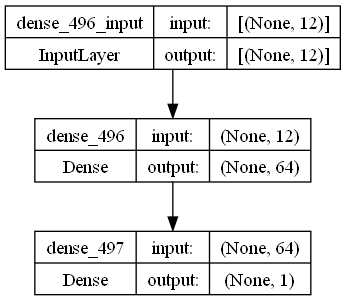

In [303]:
# Model 1
# Two dense layers (one hidden layer)
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()
plot_model(model1, to_file='model_architecture1.png', show_shapes=True)

Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_498 (Dense)           (None, 64)                832       
                                                                 
 dense_499 (Dense)           (None, 32)                2080      
                                                                 
 dense_500 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


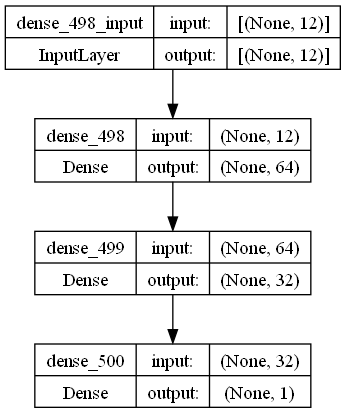

In [304]:
# Model 2
# Three dense layers (two hidden layers)
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()
plot_model(model2, to_file='model_architecture2.png', show_shapes=True)

Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_501 (Dense)           (None, 64)                832       
                                                                 
 dense_502 (Dense)           (None, 64)                4160      
                                                                 
 dense_503 (Dense)           (None, 32)                2080      
                                                                 
 dense_504 (Dense)           (None, 1)                 33        
                                                                 
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________


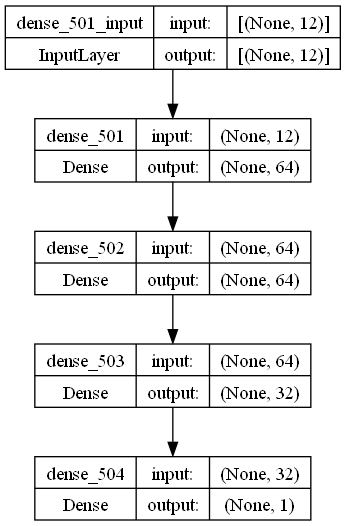

In [305]:
# Model 3
# Four dense layers (three hidden layers)
model3 = Sequential()
model3.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()
plot_model(model3, to_file='model_architecture3.png', show_shapes=True)

Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_505 (Dense)           (None, 64)                832       
                                                                 
 dropout_55 (Dropout)        (None, 64)                0         
                                                                 
 dense_506 (Dense)           (None, 32)                2080      
                                                                 
 dropout_56 (Dropout)        (None, 32)                0         
                                                                 
 dense_507 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


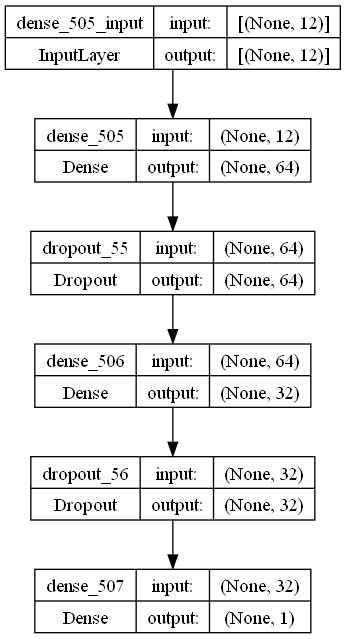

In [306]:
# Model 4
# Three dense layers with dropout
model4 = Sequential()
model4.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))

model4.summary()
plot_model(model4, to_file='model_architecture4.png', show_shapes=True)

Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_508 (Dense)           (None, 64)                832       
                                                                 
 batch_normalization_33 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_57 (Dropout)        (None, 64)                0         
                                                                 
 dense_509 (Dense)           (None, 64)                4160      
                                                                 
 batch_normalization_34 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_58 (Dropout)        (None, 64)             

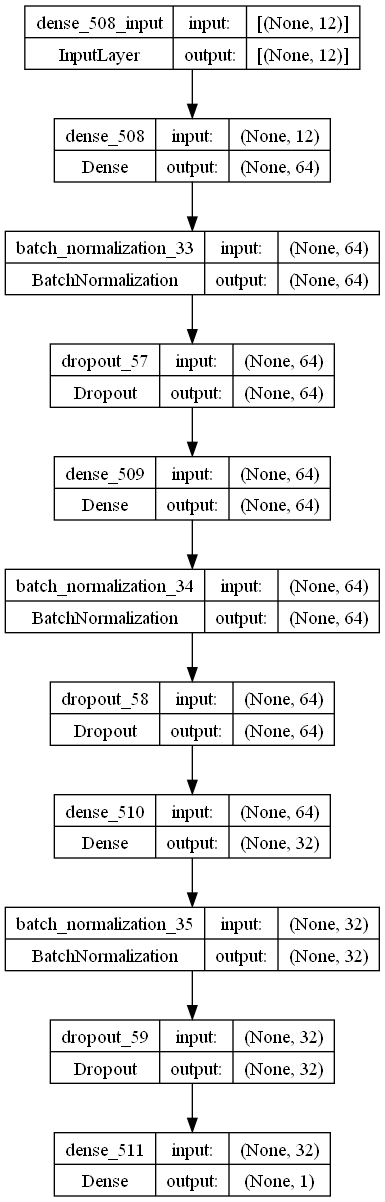

In [307]:
# Model 5
# Four dense layers with dropout and batch normalisation
model5 = Sequential()
model5.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(32, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(1, activation='sigmoid'))

model5.summary()
plot_model(model5, to_file='model_architecture5.png', show_shapes=True)

Training model 1
Epoch 1/100
96/96 [==============================] - 3s 10ms/step - loss: 0.5060 - accuracy: 0.7534 - val_loss: 0.3790 - val_accuracy: 0.7948
Epoch 2/100
96/96 [==============================] - 0s 4ms/step - loss: 0.2820 - accuracy: 0.8947 - val_loss: 0.2081 - val_accuracy: 0.9342
Epoch 3/100
96/96 [==============================] - 1s 5ms/step - loss: 0.1610 - accuracy: 0.9662 - val_loss: 0.1281 - val_accuracy: 0.9709
Epoch 4/100
96/96 [==============================] - 1s 5ms/step - loss: 0.1121 - accuracy: 0.9747 - val_loss: 0.0955 - val_accuracy: 0.9801
Epoch 5/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0874 - accuracy: 0.9813 - val_loss: 0.0793 - val_accuracy: 0.9893
Epoch 6/100
96/96 [==============================] - 0s 4ms/step - loss: 0.0742 - accuracy: 0.9823 - val_loss: 0.0682 - val_accuracy: 0.9877
Epoch 7/100
96/96 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.9849 - val_loss: 0.0629 - val_accuracy: 0.

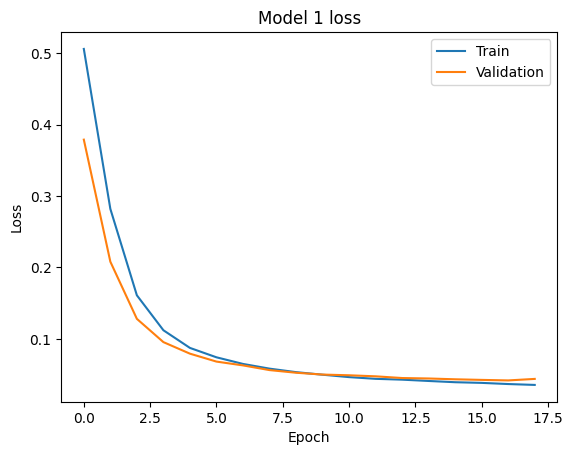

Training model 2
Epoch 1/100
96/96 [==============================] - 4s 14ms/step - loss: 0.4502 - accuracy: 0.7947 - val_loss: 0.2305 - val_accuracy: 0.9418
Epoch 2/100
96/96 [==============================] - 1s 6ms/step - loss: 0.1291 - accuracy: 0.9728 - val_loss: 0.0770 - val_accuracy: 0.9877
Epoch 3/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0645 - accuracy: 0.9843 - val_loss: 0.0538 - val_accuracy: 0.9908
Epoch 4/100
96/96 [==============================] - 0s 5ms/step - loss: 0.0508 - accuracy: 0.9869 - val_loss: 0.0463 - val_accuracy: 0.9923
Epoch 5/100
96/96 [==============================] - 0s 4ms/step - loss: 0.0431 - accuracy: 0.9888 - val_loss: 0.0429 - val_accuracy: 0.9923
Epoch 6/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0379 - accuracy: 0.9898 - val_loss: 0.0427 - val_accuracy: 0.9908
Epoch 7/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0366 - accuracy: 0.9902 - val_loss: 0.0371 - val_accuracy: 0.

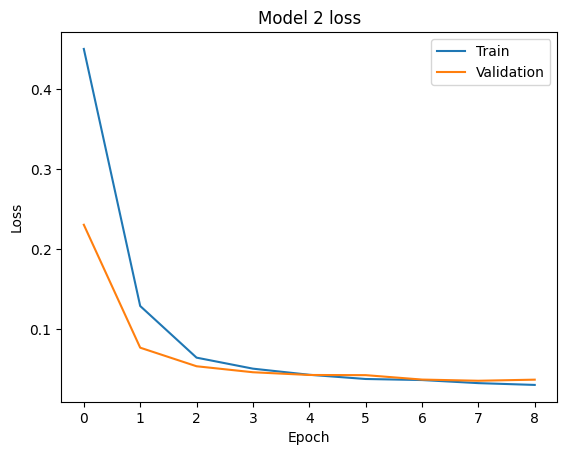

Training model 3
Epoch 1/100
96/96 [==============================] - 3s 9ms/step - loss: 0.3126 - accuracy: 0.8718 - val_loss: 0.0922 - val_accuracy: 0.9847
Epoch 2/100
96/96 [==============================] - 1s 5ms/step - loss: 0.0653 - accuracy: 0.9836 - val_loss: 0.0504 - val_accuracy: 0.9908
Epoch 3/100
96/96 [==============================] - 1s 7ms/step - loss: 0.0470 - accuracy: 0.9882 - val_loss: 0.0521 - val_accuracy: 0.9877
Epoch 3: early stopping


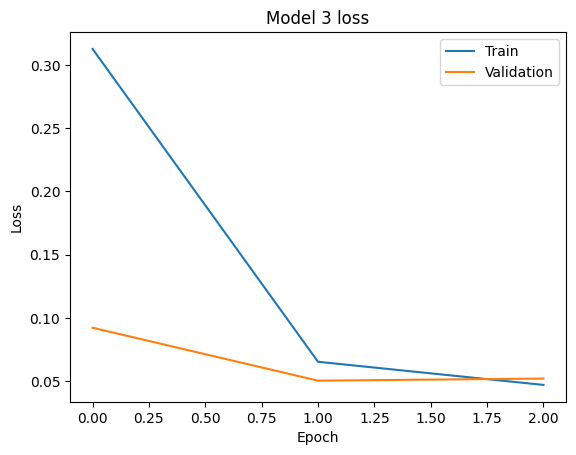

Training model 4
Epoch 1/100
96/96 [==============================] - 3s 8ms/step - loss: 0.4747 - accuracy: 0.7747 - val_loss: 0.3034 - val_accuracy: 0.8178
Epoch 2/100
96/96 [==============================] - 0s 5ms/step - loss: 0.2551 - accuracy: 0.9006 - val_loss: 0.1334 - val_accuracy: 0.9678
Epoch 3/100
96/96 [==============================] - 0s 5ms/step - loss: 0.1479 - accuracy: 0.9544 - val_loss: 0.0783 - val_accuracy: 0.9862
Epoch 4/100
96/96 [==============================] - 0s 5ms/step - loss: 0.1107 - accuracy: 0.9715 - val_loss: 0.0591 - val_accuracy: 0.9893
Epoch 5/100
96/96 [==============================] - 0s 5ms/step - loss: 0.0874 - accuracy: 0.9734 - val_loss: 0.0503 - val_accuracy: 0.9923
Epoch 6/100
96/96 [==============================] - 0s 5ms/step - loss: 0.0865 - accuracy: 0.9761 - val_loss: 0.0466 - val_accuracy: 0.9939
Epoch 7/100
96/96 [==============================] - 0s 5ms/step - loss: 0.0760 - accuracy: 0.9816 - val_loss: 0.0439 - val_accuracy: 0.9

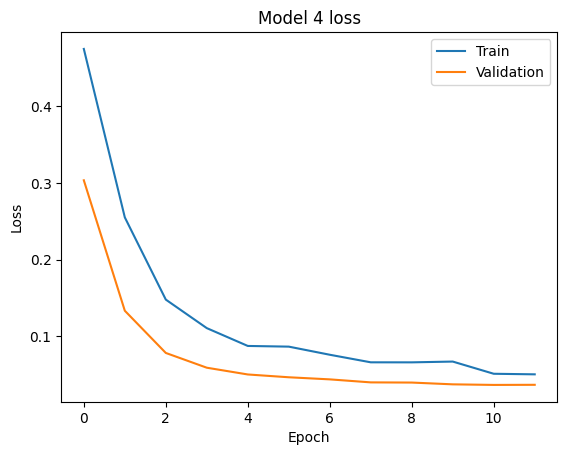

Training model 5
Epoch 1/100
96/96 [==============================] - 5s 11ms/step - loss: 0.5574 - accuracy: 0.7383 - val_loss: 0.3681 - val_accuracy: 0.9387
Epoch 2/100
96/96 [==============================] - 1s 6ms/step - loss: 0.2417 - accuracy: 0.9157 - val_loss: 0.1907 - val_accuracy: 0.9556
Epoch 3/100
96/96 [==============================] - 1s 7ms/step - loss: 0.1477 - accuracy: 0.9583 - val_loss: 0.0831 - val_accuracy: 0.9893
Epoch 4/100
96/96 [==============================] - 1s 8ms/step - loss: 0.1183 - accuracy: 0.9692 - val_loss: 0.0439 - val_accuracy: 0.9954
Epoch 5/100
96/96 [==============================] - 1s 7ms/step - loss: 0.0932 - accuracy: 0.9741 - val_loss: 0.0327 - val_accuracy: 0.9939
Epoch 6/100
96/96 [==============================] - 1s 7ms/step - loss: 0.0879 - accuracy: 0.9747 - val_loss: 0.0294 - val_accuracy: 0.9939
Epoch 7/100
96/96 [==============================] - 1s 7ms/step - loss: 0.0787 - accuracy: 0.9784 - val_loss: 0.0287 - val_accuracy: 0.

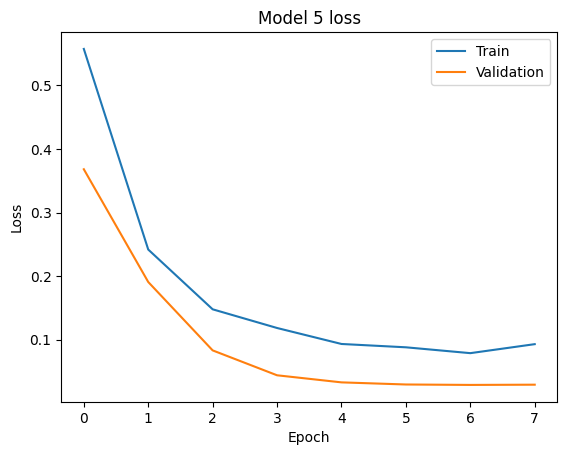

The best model is Model 5 with validation accuracy: 0.9954057931900024


In [308]:
models = [model1, model2, model3, model4, model5]
best_validation_accuracy = 0.0

# Compile and train models
for i, model in enumerate(models, 1):
    print(f'Training model {i}')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[es])
    
    # Retrieve the validation accuracy from history
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Check if the current model has the highest validation accuracy
    if val_accuracy > best_validation_accuracy:
        best_model = model
        best_validation_accuracy = val_accuracy
        best_model_index = i

    # Plot training/validation loss
    plt.figure(i)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model {i} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

# After training all models, the best model will be stored in 'best_model' variable
print(f'The best model is Model {best_model_index} with validation accuracy: {best_validation_accuracy}')

In [309]:
# Print the architecture of the best model
best_model.summary()

# Display the best model and its validation accuracy
print(f"The best model is: Model {best_model_index} with validation accuracy: {best_validation_accuracy}")

Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_508 (Dense)           (None, 64)                832       
                                                                 
 batch_normalization_33 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_57 (Dropout)        (None, 64)                0         
                                                                 
 dense_509 (Dense)           (None, 64)                4160      
                                                                 
 batch_normalization_34 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_58 (Dropout)        (None, 64)             

## (d) Model Tuning
- Hyperparameters tuning

In [310]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import random


# Create an empty DataFrame
results_table = pd.DataFrame(columns=['Activation Function', 'Learning Rate', 'Optimizer', 'Accuracy'])

# Define the hyperparameter values
activations = ['relu', 'sigmoid', 'tanh']
learning_rates = [0.1, 0.01, 0.001]
optimizers = ['adam', 'sgd', 'rmsprop']

# Set the number of combinations to evaluate
num_evaluations = 10

# Perform random search
for _ in range(num_evaluations):
    # Randomly select hyperparameters
    activation = random.choice(activations)
    learning_rate = random.choice(learning_rates)
    optimizer = random.choice(optimizers)

    # Create a new instance of the model
    model = tf.keras.Sequential([
        layers.Dense(64, activation=activation, input_shape=(X_train.shape[1],)),
        layers.Dense(32, activation=activation),
        layers.Dense(16, activation=activation),
        layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model with the current hyperparameters
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on the test set
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Record the results in the table
    results_table = pd.concat([results_table, pd.DataFrame([[activation, learning_rate, optimizer, accuracy]],
                                                           columns=['Activation Function', 'Learning Rate', 'Optimizer', 'Accuracy'])], ignore_index=True)
    
    # Print the results in a table
print(results_table)
print()

# Sort the results table by accuracy in descending order
results_table_sorted = results_table.sort_values(by='Accuracy', ascending=False)

# Retrieve the best hyperparameters (top row)
best_hyperparameters = results_table_sorted.iloc[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print("Activation Function:", best_hyperparameters['Activation Function'])
print("Learning Rate:", best_hyperparameters['Learning Rate'])
print("Optimizer:", best_hyperparameters['Optimizer'])
print("Accuracy:", best_hyperparameters['Accuracy'])

  Activation Function  Learning Rate Optimizer  Accuracy
0             sigmoid          0.010       sgd  0.781346
1                relu          0.100       sgd  0.966361
2                relu          0.010   rmsprop  0.990826
3                relu          0.010       sgd  0.969419
4             sigmoid          0.010      adam  0.987768
5             sigmoid          0.010       sgd  0.781346
6                tanh          0.010      adam  0.987768
7                relu          0.001      adam  0.992355
8                tanh          0.100      adam  0.984710
9                relu          0.010      adam  0.989297

Best Hyperparameters:
Activation Function: relu
Learning Rate: 0.001
Optimizer: adam
Accuracy: 0.9923547506332397


## (e) Model evaluation
- Displaying confusion matrix and ROC curve

In [311]:
# Predict the test set results
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5)

21/21 [==============================] - 2s 6ms/step


In [312]:
# Compute and print the performance metrics
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

Test accuracy: 0.9923547400611621
Precision: 0.9922178988326849
Recall: 0.9980430528375733
F1 Score: 0.9951219512195121
AUC: 0.9850355124327727


In [313]:
# Compute and print the performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\n")
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[139   4]
 [  1 510]]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       143
         1.0       0.99      1.00      1.00       511

    accuracy                           0.99       654
   macro avg       0.99      0.99      0.99       654
weighted avg       0.99      0.99      0.99       654



Accuracy Score:
0.9923547400611621


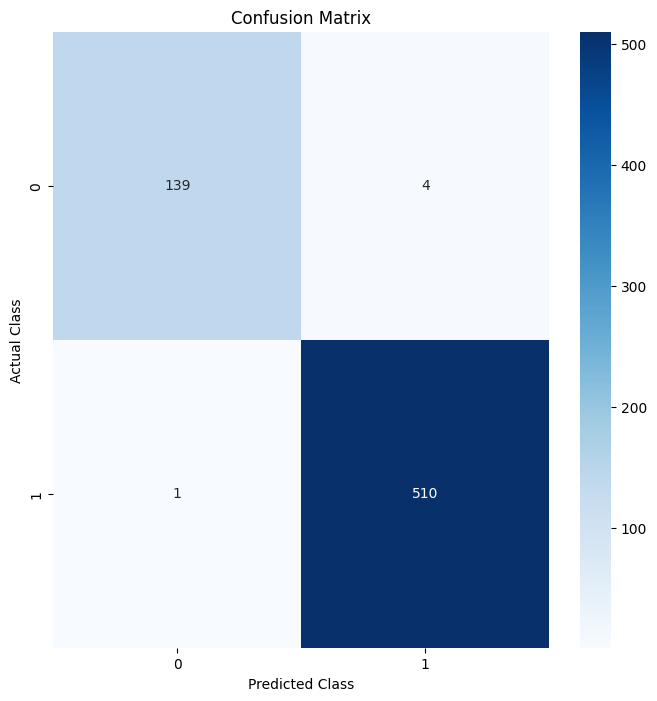

In [314]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel("Predicted Class")
plt.ylabel('Actual Class')
plt.show()

In [315]:
# Calculate the probabilities of the predictions
y_test_prob = best_model.predict(X_test)

21/21 [==============================] - 0s 3ms/step


In [316]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

In [317]:
# Calculate AUC score
auc_score = roc_auc_score(y_test, y_test_prob)

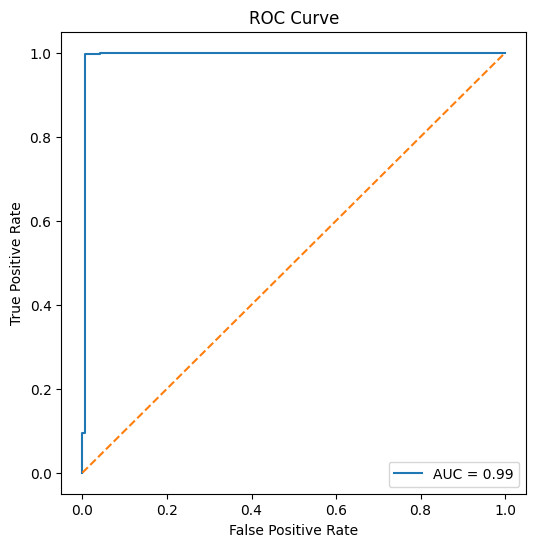

In [318]:
# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()